# Inputs

In [1]:
splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Preproccess

## read data

In [2]:
from utils.class_patient import Patients


patients = Patients.loadPatients()
len(patients)

1213

## remove missing

In [3]:
# fill measures whose null represent false value

from constants import NULLABLE_MEASURES


nullableMeasures = NULLABLE_MEASURES

for measureName in nullableMeasures:
    patients.fillMissingMeasureValue(measureName, 0)

In [4]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


In [5]:
# remove patients with less than 80% of data

patients.removePatientByMissingFeatures()
len(patients)

1206

In [6]:
# # remove patients with positive tag in first 12 hours

from pandas import Timedelta


patients.removePatientAkiEarly(Timedelta(hours=12))

82

In [7]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


## split patients

In [8]:
splitedPatients = patients.split(splitPartCount, splitSeed)

len(splitedPatients[0])

225

In [9]:
splitedPatients = patients.split(splitPartCount, splitSeed)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

In [10]:
for trainPatients, testPatients in trainTest():
    print(len(trainPatients.patientList), len(testPatients.patientList))

899 225
899 225
899 225
899 225
900 224


# Transformer

### Transformer

### Using transformer

In [20]:
from official.nlp.modeling.models import TransformerEncoder
from official.nlp.configs import encoders

# # Configuration for the Transformer encoder
# encoder_config = encoders.TransformerEncoderConfig(
#     vocab_size=30522,  # Use a large enough vocab size if working with tokenized text; adjust if needed
#     hidden_size=128,  # Example hidden size
#     num_layers=2,  # Example number of layers
#     num_attention_heads=4,  # Example number of attention heads
#     intermediate_size=512,  # Size of the feed-forward network's intermediate layer
#     activation="gelu",
#     dropout_rate=0.1,
#     attention_dropout_rate=0.1,
#     max_sequence_length=512,  # Max length of input sequences
#     type_vocab_size=2,
# )

import keras

@keras.saving.register_keras_serializable()
class ArrayToBooleanModel(keras.Model):
    def __init__(self, **kwargs):
        super(ArrayToBooleanModel, self).__init__(**kwargs)
        self.transformer_encoder = TransformerEncoder(
            dropout_rate=0.1,
            attention_dropout_rate=0.1,
            # max_sequence_length=max_sequence_length,
            # vocab_size=vocab_size,
        )
        self.pooling = keras.layers.GlobalAveragePooling1D()
        self.dense = keras.layers.Dense(
            1, activation="sigmoid"
        )  # Output a single boolean value

    def call(self, inputs, training=False):
        x = self.transformer_encoder(inputs, training=training)
        x = self.pooling(x)
        x = self.dense(x)
        return x


def createTransformerModel(timeSteps, features):
    from tensorflow.keras.optimizers import Adam
    model = ArrayToBooleanModel()

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["AUC", "accuracy", "precision", "recall"],
    )

    return model

createTransformerModel(12, 21).summary(expand_nested=True)

Model: "array_to_boolean_model_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling1d_11     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
from utils.prepare_data import normalizeData, patientsToNumpy
from constants import CATEGORICAL_MEASURES
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


if __name__ == "__main__":

    loses = []
    aucs = []
    accuracies = []
    precisions = []
    recals = []

    train_loss_list = []
    val_loss_list = []
    models = []

    for i, (trainPatients, valPatients, testPatients) in enumerate(trainValTest()):
        npTrainX, dataNormalizer = patientsToNumpy(
            trainPatients, 
            hoursPerWindow,
            timeSeriesOnly=True,
            fromHour=0,
            toHour=12,
        )

        npTestX, *_ = patientsToNumpy(
            testPatients,
            hoursPerWindow,
            timeSeriesOnly=True,
            fromHour=0,
            toHour=12,
            dataNormalizer=dataNormalizer,
            isTrainPatients=False,
        )

        npValX, *_ = patientsToNumpy(
            valPatients,
            hoursPerWindow,
            timeSeriesOnly=True,
            fromHour=0,
            toHour=12,
            dataNormalizer=dataNormalizer,
            isTrainPatients=False,
        )

        npTrainX = np.nan_to_num(npTrainX, nan=0)
        npTestX = np.nan_to_num(npTestX, nan=0)
        npValX = np.nan_to_num(npValX, nan=0)

        ################### Static ###################
        staticTrainX = trainPatients.getMeasuresBetween(measureTypes="static")
        staticTestX = testPatients.getMeasuresBetween(measureTypes="static")
        staticValX = valPatients.getMeasuresBetween(measureTypes="static")

        staticTrainX = staticTrainX.drop(columns=["subject_id", "hadm_id", "stay_id", "akd"])
        staticTestX = staticTestX.drop(columns=["subject_id", "hadm_id", "stay_id", "akd"])
        staticValX = staticValX.drop(columns=["subject_id", "hadm_id", "stay_id", "akd"])

        staticTrainX, staticTestX, staticValX = normalizeData(
            staticTrainX, staticTestX, staticValX
        )

        staticLen = len(staticTrainX.columns)

        staticTrainX = staticTrainX.to_numpy().astype(np.float32)
        staticTestX = staticTestX.to_numpy().astype(np.float32)
        staticValX = staticValX.to_numpy().astype(np.float32) # type: ignore

        staticTrainX = np.nan_to_num(staticTrainX, nan=0)
        staticTestX = np.nan_to_num(staticTestX, nan=0)
        staticValX = np.nan_to_num(staticValX, nan=0)

        ################### labels ###################
        trainY = [p.akdPositive for p in trainPatients]
        testY = [p.akdPositive for p in testPatients]
        valY = [p.akdPositive for p in valPatients]

        # model = createModel2(npTrainX.shape[1], npTrainX.shape[2], staticLen)

        neg, pos = np.bincount(trainY)
        weight0 = (1 / neg) * (len(trainY)) / 2.0
        weight1 = (1 / pos) * (len(trainY)) / 2.0
        weight = {0: weight0, 1: weight1}

        # expand static data to be time steps as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)

        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)


        early_stopping = EarlyStopping(
                monitor="val_loss", patience=50, restore_best_weights=True
            )

        model = createTransformerModel(npTrainX.shape[1], npTrainX.shape[2] + staticLen)
        history = model.fit(
                npTrainX,
                np.array(trainY),
                epochs=1000,
                batch_size=32,
                validation_data=(npValX, np.array(valY)),
                class_weight=weight,
                callbacks=[early_stopping],
            )

        loss, auc, accuracy, precison, recal = model.evaluate(npTestX, np.array(testY)) 
                    
        # model.save(f"result/transformer_only_{i}.h5")

        models.append(model)
        loses.append(loss)
        aucs.append(auc)
        accuracies.append(accuracy)
        precisions.append(precison)
        recals.append(recal)

        train_loss_list.append(history.history['loss'])
        val_loss_list.append(history.history['val_loss'])

        pass

Epoch 1/1000


I0000 00:00:1724459771.133008 3507099 service.cc:146] XLA service 0x796d2c019510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724459771.133030 3507099 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-08-24 07:36:11.178012: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-24 07:36:11.197343: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. array_to_boolean_model_1_1/transformer_encoder_1/layer_0/self_attention/dropout_3/dropout/random_uniform/RandomUniform
2024-08-24 07:36:11.592541: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-24 07:36:12.191578: I ex

 1/23 ━━━━━━━━━━━━━━━━━━━━ 1:45 5s/step - AUC: 0.5385 - accuracy: 0.5000 - loss: 0.7770 - precision: 0.4400 - recall: 0.8462

I0000 00:00:1724459774.079874 3507099 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-08-24 07:36:15.131357: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 236 bytes spill stores, 236 bytes spill loads

2024-08-24 07:36:15.211304: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 20 bytes spill stores, 20 bytes spill loads

2024-08-24 07:36:15.264434: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 468 bytes spill stores, 320 bytes spill loads



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - AUC: 0.5259 - accuracy: 0.4308 - loss: 0.8017 - precision: 0.3636 - recall: 0.7697

2024-08-24 07:36:18.876040: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 140 bytes spill stores, 140 bytes spill loads

2024-08-24 07:36:18.889825: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 260 bytes spill stores, 260 bytes spill loads

2024-08-24 07:36:18.910114: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 12 bytes spill stores, 12 bytes spill loads

2024-08-24 07:36:18.954383: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 16 bytes spill stores, 16 bytes spill loads

2024-08-24 07:36:19.091666: I external/local_xla/xla/stream_executor

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - AUC: 0.5250 - accuracy: 0.4295 - loss: 0.8025 - precision: 0.3625 - recall: 0.7683 - val_AUC: 0.4377 - val_accuracy: 0.3575 - val_loss: 1.1155 - val_precision: 0.3354 - val_recall: 0.8710
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5232 - accuracy: 0.4234 - loss: 0.8017 - precision: 0.3747 - recall: 0.7584 - val_AUC: 0.4495 - val_accuracy: 0.3631 - val_loss: 1.0886 - val_precision: 0.3375 - val_recall: 0.8710
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5025 - accuracy: 0.3915 - loss: 0.8048 - precision: 0.3299 - recall: 0.7568 - val_AUC: 0.4626 - val_accuracy: 0.3687 - val_loss: 1.0625 - val_precision: 0.3396 - val_recall: 0.8710
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5270 - accuracy: 0.4260 - loss: 0.7854 - precision: 0.3637 - recall: 0.6933 - val_AUC: 0.4794 - val_accuracy: 0.3687 - val_loss: 1.0375 - val_precision: 0.3396 - val_recall: 0.8710
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s

2024-08-24 07:36:44.245081: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 416 bytes spill stores, 408 bytes spill loads

2024-08-24 07:36:44.310391: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 12 bytes spill stores, 12 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - AUC: 0.8034 - accuracy: 0.7425 - loss: 0.5186 - precision: 0.6923 - recall: 0.5574
Epoch 1/1000


2024-08-24 07:37:45.621171: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 132 bytes spill stores, 132 bytes spill loads

2024-08-24 07:37:45.663990: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 20 bytes spill stores, 20 bytes spill loads

2024-08-24 07:37:45.683121: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 348 bytes spill stores, 296 bytes spill loads



 1/23 ━━━━━━━━━━━━━━━━━━━━ 1:40 5s/step - AUC: 0.5000 - accuracy: 0.3125 - loss: 0.8804 - precision: 0.2917 - recall: 0.5833

2024-08-24 07:37:48.487535: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 4 bytes spill stores, 4 bytes spill loads

2024-08-24 07:37:48.559951: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 132 bytes spill stores, 132 bytes spill loads

2024-08-24 07:37:48.759847: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 620 bytes spill stores, 408 bytes spill loads



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - AUC: 0.4253 - accuracy: 0.3992 - loss: 0.9538 - precision: 0.3311 - recall: 0.6033

2024-08-24 07:37:52.236463: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 204 bytes spill stores, 204 bytes spill loads

2024-08-24 07:37:52.239639: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 620 bytes spill stores, 408 bytes spill loads



23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - AUC: 0.4254 - accuracy: 0.3996 - loss: 0.9532 - precision: 0.3306 - recall: 0.6033 - val_AUC: 0.4002 - val_accuracy: 0.4358 - val_loss: 0.8806 - val_precision: 0.2532 - val_recall: 0.3226
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.4385 - accuracy: 0.4183 - loss: 0.9067 - precision: 0.3288 - recall: 0.5875 - val_AUC: 0.4104 - val_accuracy: 0.4413 - val_loss: 0.8649 - val_precision: 0.2564 - val_recall: 0.3226
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.4036 - accuracy: 0.3913 - loss: 0.9537 - precision: 0.3299 - recall: 0.5884 - val_AUC: 0.4177 - val_accuracy: 0.4525 - val_loss: 0.8505 - val_precision: 0.2568 - val_recall: 0.3065
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.4548 - accuracy: 0.4462 - loss: 0.8870 - precision: 0.3483 - recall: 0.6470 - val_AUC: 0.4278 - val_accuracy: 0.4581 - val_loss: 0.8361 - val_precision: 0.2603 - val_recall: 0.3065
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s

2024-08-24 07:41:28.812798: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 60 bytes spill stores, 60 bytes spill loads

2024-08-24 07:41:28.838335: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 188 bytes spill stores, 188 bytes spill loads

2024-08-24 07:41:28.970430: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 380 bytes spill stores, 328 bytes spill loads



 1/23 ━━━━━━━━━━━━━━━━━━━━ 1:44 5s/step - AUC: 0.5000 - accuracy: 0.5625 - loss: 0.9190 - precision: 0.4286 - recall: 0.5000

2024-08-24 07:41:31.936413: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 12 bytes spill stores, 12 bytes spill loads

2024-08-24 07:41:32.063454: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 188 bytes spill stores, 188 bytes spill loads

2024-08-24 07:41:32.185991: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 676 bytes spill stores, 484 bytes spill loads



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - AUC: 0.5661 - accuracy: 0.5634 - loss: 0.7999 - precision: 0.4113 - recall: 0.5831

2024-08-24 07:41:35.661717: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 48 bytes spill stores, 48 bytes spill loads

2024-08-24 07:41:35.716847: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 236 bytes spill stores, 236 bytes spill loads

2024-08-24 07:41:35.782744: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 676 bytes spill stores, 484 bytes spill loads



23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - AUC: 0.5669 - accuracy: 0.5636 - loss: 0.7989 - precision: 0.4115 - recall: 0.5832 - val_AUC: 0.5726 - val_accuracy: 0.5419 - val_loss: 0.8885 - val_precision: 0.4000 - val_recall: 0.6452
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5526 - accuracy: 0.5742 - loss: 0.8072 - precision: 0.3970 - recall: 0.5919 - val_AUC: 0.5783 - val_accuracy: 0.5531 - val_loss: 0.8787 - val_precision: 0.4100 - val_recall: 0.6613
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.6180 - accuracy: 0.6087 - loss: 0.7621 - precision: 0.4720 - recall: 0.5876 - val_AUC: 0.5842 - val_accuracy: 0.5642 - val_loss: 0.8701 - val_precision: 0.4200 - val_recall: 0.6774
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5989 - accuracy: 0.5949 - loss: 0.7709 - precision: 0.4543 - recall: 0.6140 - val_AUC: 0.5892 - val_accuracy: 0.5698 - val_loss: 0.8611 - val_precision: 0.4242 - val_recall: 0.6774
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s

2024-08-24 07:43:11.692732: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 204 bytes spill stores, 204 bytes spill loads

2024-08-24 07:43:11.761352: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 620 bytes spill stores, 408 bytes spill loads



23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - AUC: 0.5097 - accuracy: 0.4955 - loss: 0.8137 - precision: 0.3533 - recall: 0.4455 - val_AUC: 0.4926 - val_accuracy: 0.4000 - val_loss: 0.9438 - val_precision: 0.3140 - val_recall: 0.6032
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5283 - accuracy: 0.5424 - loss: 0.7811 - precision: 0.3770 - recall: 0.5124 - val_AUC: 0.5008 - val_accuracy: 0.4000 - val_loss: 0.9327 - val_precision: 0.3140 - val_recall: 0.6032
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5364 - accuracy: 0.5459 - loss: 0.7688 - precision: 0.3710 - recall: 0.4947 - val_AUC: 0.5089 - val_accuracy: 0.4000 - val_loss: 0.9220 - val_precision: 0.3140 - val_recall: 0.6032
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5557 - accuracy: 0.5530 - loss: 0.7482 - precision: 0.3824 - recall: 0.5337 - val_AUC: 0.5176 - val_accuracy: 0.4000 - val_loss: 0.9115 - val_precision: 0.3140 - val_recall: 0.6032
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:

print("Loses:", loses, np.mean(loses), np.std(loses))
print("AUCs:", aucs, np.mean(aucs), np.std(aucs))
print("Accuracies:", accuracies, np.mean(accuracies), np.std(accuracies))
print("Precisions:", precisions, np.mean(precisions), np.std(precisions))
print("Recals:", recals, np.mean(recals), np.std(recals));

Loses: [0.5014221668243408, 0.5609717965126038, 0.541408121585846, 0.576999306678772, 0.6050240397453308] 0.5571650862693787 0.034796326743585154
AUCs: [0.8170678615570068, 0.8160647749900818, 0.7641754746437073, 0.7997225522994995, 0.7835879325866699] 0.796123719215393 0.020134997794960936
Accuracies: [0.7822222113609314, 0.7111111283302307, 0.7288888692855835, 0.7377777695655823, 0.6964285969734192] 0.7312857151031494 0.029204283685115132
Precisions: [0.6705882549285889, 0.5596330165863037, 0.6184210777282715, 0.5943396091461182, 0.5431034564971924] 0.5972170829772949 0.04512663235798874
Recals: [0.7307692170143127, 0.7820512652397156, 0.594936728477478, 0.797468364238739, 0.807692289352417] 0.7425835728645325 0.07841983638075596


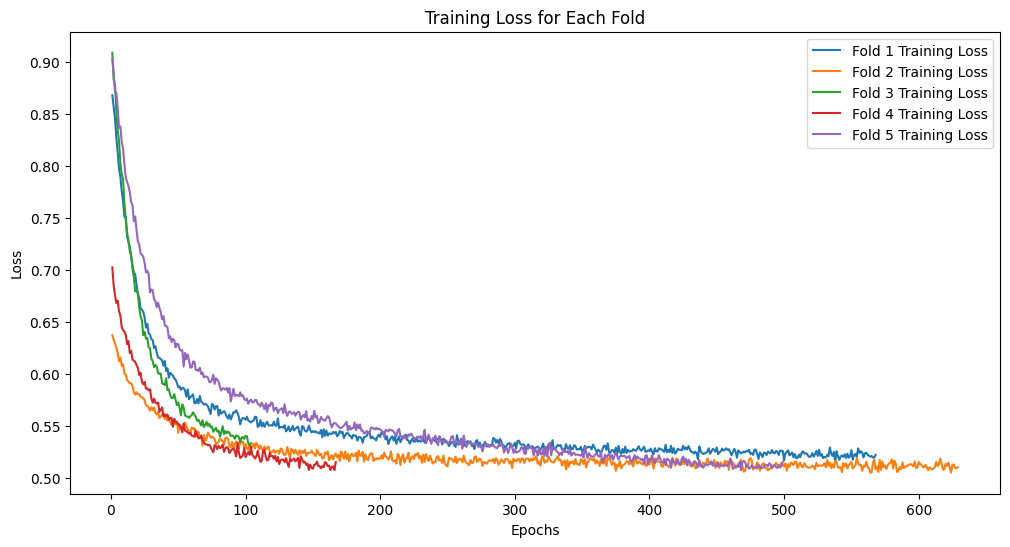

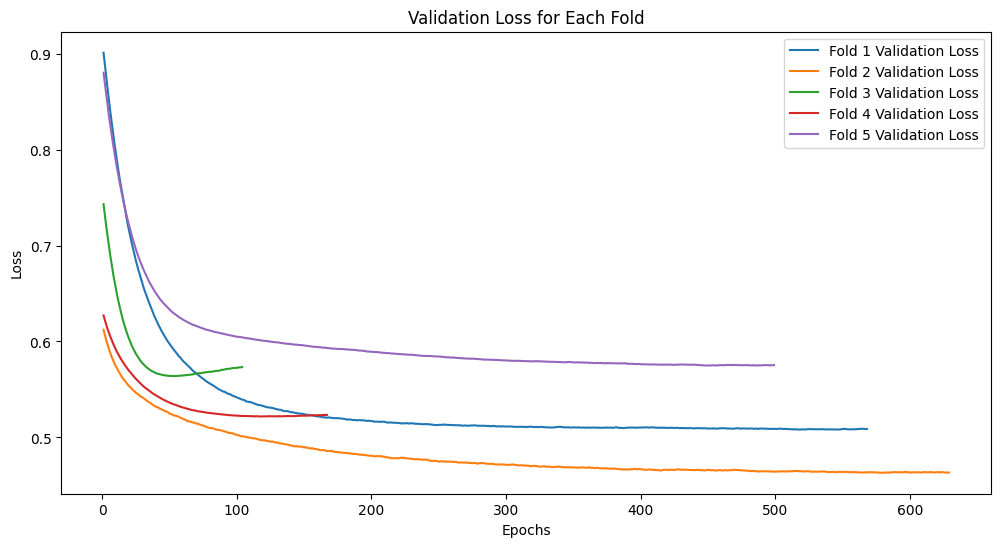

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1), train_loss, label=f"Fold {i+1} Training Loss"
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# plt.savefig("result/transformer_only_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(range(1, len(val_loss) + 1), val_loss, label=f"Fold {i+1} Validation Loss")
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# plt.savefig("result/transformer_only_val_loss.svg")
plt.show()